In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary

import os
import time


데이터 파싱

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataDir = './dataset/AI-DATASET/data'

trainData_dir = os.path.join(dataDir, 'trainData')
train_dir = os.path.join(dataDir, 'train')
test_dir = os.path.join(dataDir, 'test')

# train, test 폴더 생성
train_set_dir = os.path.join(train_dir, 'train')
test_set_dir = os.path.join(train_dir, 'test')

데이터 전처리

In [9]:

# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_datasets = torchvision.datasets.ImageFolder(os.path.join(train_set_dir), transforms_train)
test_datasets = torchvision.datasets.ImageFolder(os.path.join(test_set_dir), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
class_validate_names = test_datasets.classes
print('클래스:', class_names)
print('검증 클래스: ', class_validate_names)

학습 데이터셋 크기: 4103
테스트 데이터셋 크기: 566
클래스: ['beverage_bottle_glass', 'beverage_can', 'beverage_milk_coffee', 'dailyneccsity_toothe', 'dailynecessity_etc', 'iceCream_Corn', 'iceCream_etc', 'iceCream_pint', 'instanceFood_Bag', 'instanceFood_Sauage', 'instanceFood_etc', 'noodle', 'snack_bag', 'snack_box']
검증 클래스:  ['beverage_bottle_glass', 'beverage_can', 'beverage_milk_coffee', 'dailyneccsity_toothe', 'dailynecessity_etc', 'iceCream_Corn', 'iceCream_etc', 'iceCream_pint', 'instanceFood_Bag', 'instanceFood_Sauage', 'instanceFood_etc', 'noodle', 'snack_bag', 'snack_box']


사용할 모델

In [10]:
model = torchvision.models.resnet34(weights=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 n개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 14)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

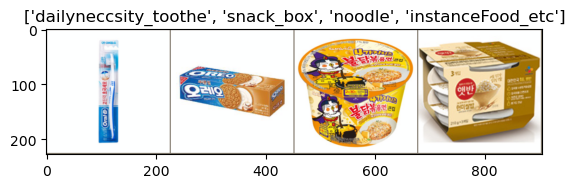

In [11]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])


In [15]:
num_epochs = 15
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 1.0874 Acc: 66.3173% Time: 44.4896s
#1 Loss: 0.5910 Acc: 82.3056% Time: 79.2710s
#2 Loss: 0.3574 Acc: 89.6661% Time: 115.0404s
#3 Loss: 0.3129 Acc: 90.8360% Time: 150.0072s
#4 Loss: 0.2143 Acc: 93.9069% Time: 185.3676s
#5 Loss: 0.1815 Acc: 95.1499% Time: 221.4046s
#6 Loss: 0.1597 Acc: 95.8079% Time: 257.6690s
#7 Loss: 0.1296 Acc: 96.3441% Time: 293.9937s
#8 Loss: 0.1195 Acc: 96.8560% Time: 329.7467s
#9 Loss: 0.0956 Acc: 97.2703% Time: 365.5112s
#10 Loss: 0.0978 Acc: 97.2459% Time: 400.7601s
#11 Loss: 0.0993 Acc: 97.5140% Time: 436.1620s
#12 Loss: 0.0820 Acc: 97.2459% Time: 471.7229s
#13 Loss: 0.0744 Acc: 97.7577% Time: 506.9671s
#14 Loss: 0.0674 Acc: 98.0502% Time: 543.0168s
#15 Loss: 0.0629 Acc: 98.0258% Time: 578.1616s
#16 Loss: 0.0556 Acc: 98.0258% Time: 613.3125s
#17 Loss: 0.0671 Acc: 98.2208% Time: 648.9384s
#18 Loss: 0.0509 Acc: 98.3427% Time: 684.2103s
#19 Loss: 0.0456 Acc: 98.4402% Time: 719.9588s


[예측 결과: noodle] (실제 정답: noodle)


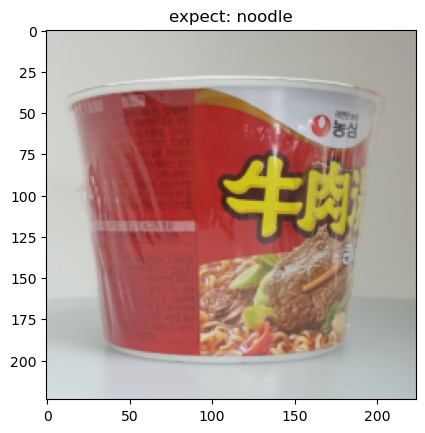

[예측 결과: iceCream_pint] (실제 정답: iceCream_pint)


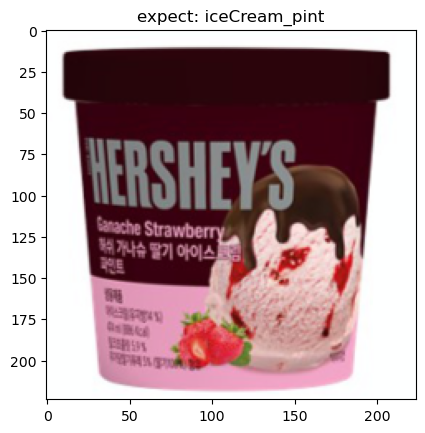

[예측 결과: noodle] (실제 정답: noodle)


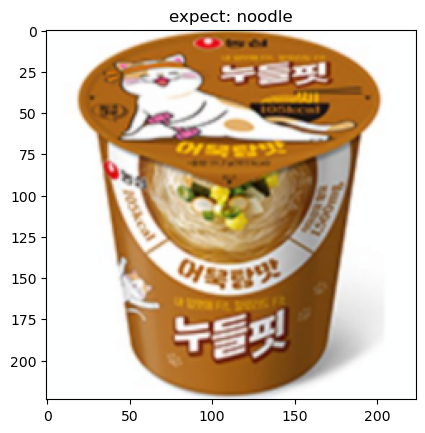

[예측 결과: noodle] (실제 정답: noodle)


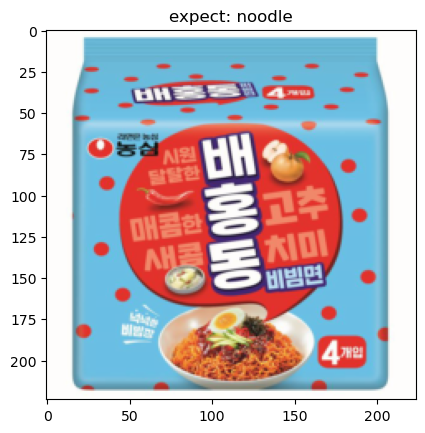

[예측 결과: noodle] (실제 정답: noodle)


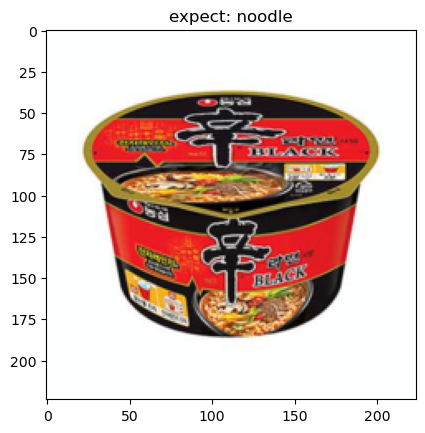

[예측 결과: noodle] (실제 정답: noodle)


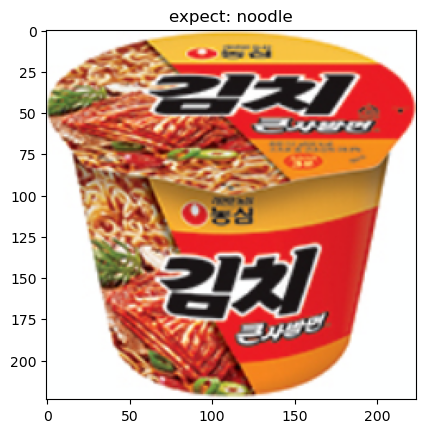

[예측 결과: beverage_milk_coffee] (실제 정답: dailynecessity_etc)


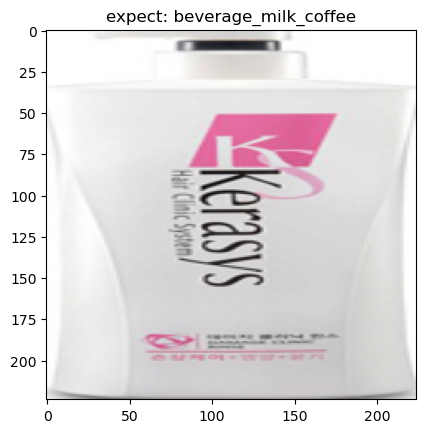

[예측 결과: dailynecessity_etc] (실제 정답: dailynecessity_etc)


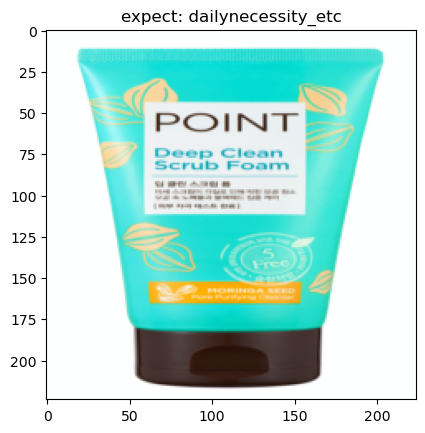

[예측 결과: dailynecessity_etc] (실제 정답: dailynecessity_etc)


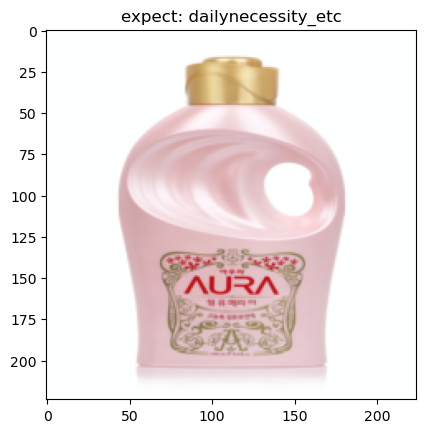

[예측 결과: snack_bag] (실제 정답: snack_bag)


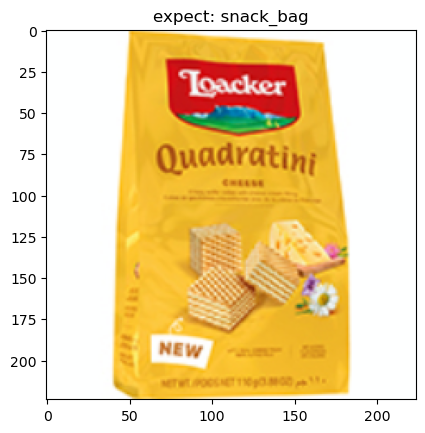

[예측 결과: instanceFood_etc] (실제 정답: instanceFood_etc)


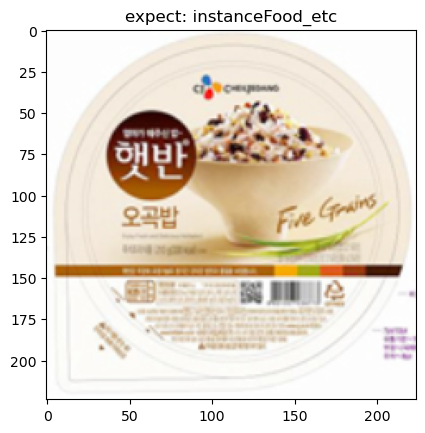

[예측 결과: noodle] (실제 정답: noodle)


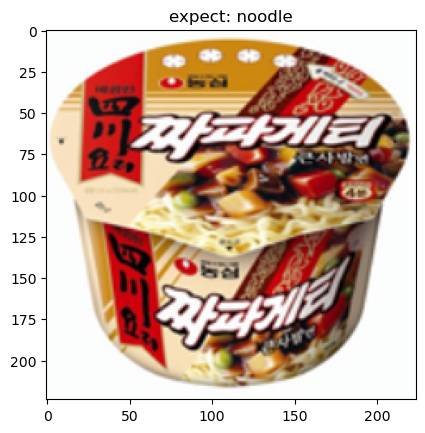

[예측 결과: noodle] (실제 정답: noodle)


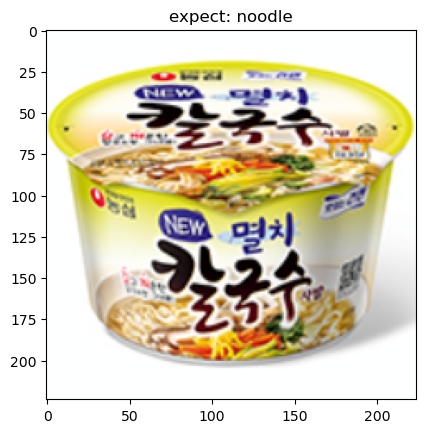

[예측 결과: iceCream_etc] (실제 정답: iceCream_etc)


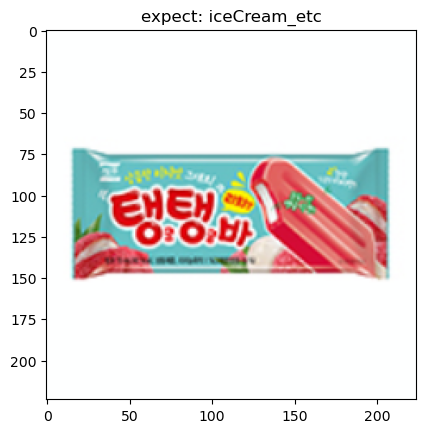

[예측 결과: dailyneccsity_toothe] (실제 정답: dailyneccsity_toothe)


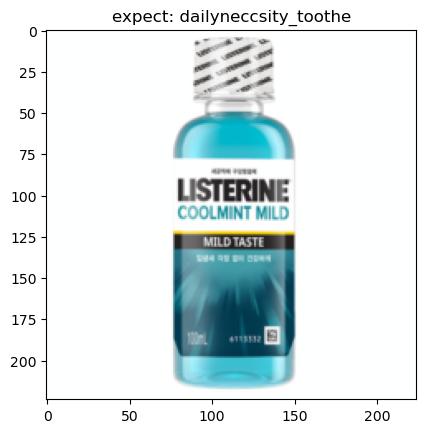

[예측 결과: iceCream_Corn] (실제 정답: iceCream_Corn)


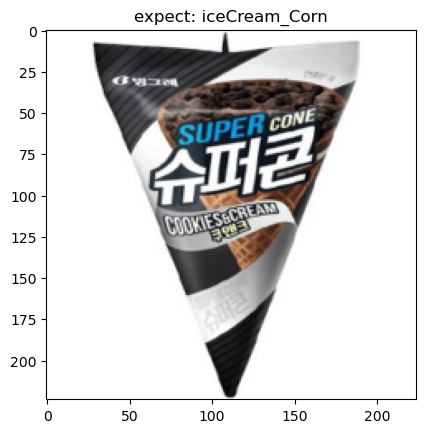

[예측 결과: beverage_milk_coffee] (실제 정답: beverage_milk_coffee)


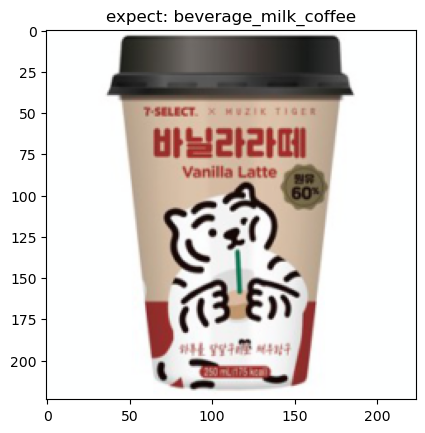

[예측 결과: iceCream_pint] (실제 정답: iceCream_pint)


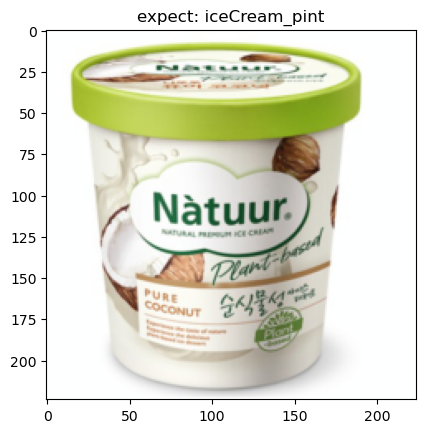

[예측 결과: snack_bag] (실제 정답: snack_bag)


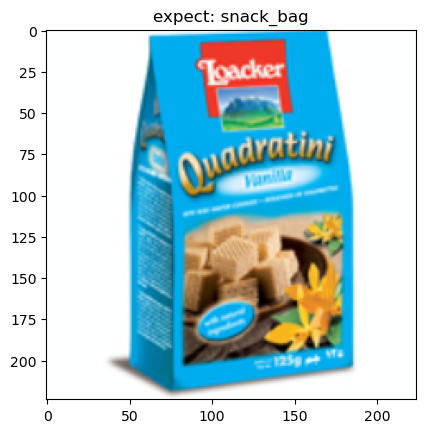

[예측 결과: iceCream_etc] (실제 정답: iceCream_etc)


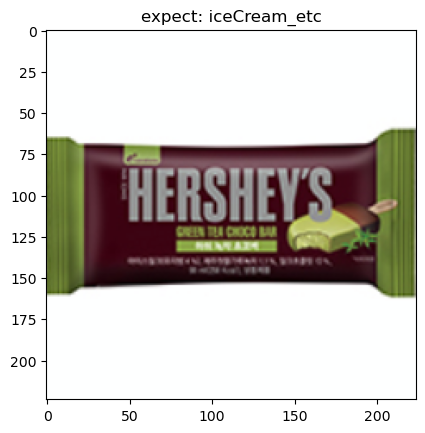

[예측 결과: instanceFood_etc] (실제 정답: instanceFood_etc)
[예측 결과: iceCream_etc] (실제 정답: iceCream_etc)
[예측 결과: snack_box] (실제 정답: snack_box)
[예측 결과: instanceFood_Sauage] (실제 정답: instanceFood_Sauage)
[예측 결과: iceCream_Corn] (실제 정답: iceCream_Corn)
[예측 결과: snack_bag] (실제 정답: snack_bag)
[예측 결과: beverage_can] (실제 정답: beverage_can)
[예측 결과: dailynecessity_etc] (실제 정답: dailynecessity_etc)
[예측 결과: beverage_can] (실제 정답: beverage_can)
[예측 결과: instanceFood_Sauage] (실제 정답: instanceFood_Sauage)
[예측 결과: noodle] (실제 정답: noodle)
[예측 결과: dailyneccsity_toothe] (실제 정답: dailynecessity_etc)
[예측 결과: iceCream_etc] (실제 정답: iceCream_etc)
[예측 결과: dailyneccsity_toothe] (실제 정답: dailyneccsity_toothe)
[예측 결과: beverage_can] (실제 정답: beverage_can)
[예측 결과: noodle] (실제 정답: noodle)
[예측 결과: noodle] (실제 정답: noodle)
[예측 결과: noodle] (실제 정답: noodle)
[예측 결과: noodle] (실제 정답: noodle)
[예측 결과: dailyneccsity_toothe] (실제 정답: dailynecessity_etc)
[예측 결과: snack_box] (실제 정답: snack_box)
[예측 결과: iceCream_pint] (실제 정답: iceCream_pint)
[예측 결과: noodle

In [16]:
model.eval()
start_time = time.time()
cnt = 0


with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
            

        if cnt < 20:   
            print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
            imshow(inputs.cpu().data[0], title='expect: ' + class_names[preds[0]])
        else:
            print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        cnt += 1

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

In [17]:
torch.save(model.state_dict(),'./PyeonHaengModel_ver1.pth')

cnn_model =  torchvision.models.resnet34(weights=True)
num_features2 = cnn_model.fc.in_features
cnn_model.fc = nn.Linear(num_features, 14)
cnn_model.load_state_dict(torch.load('./PyeonHaengModel_ver1.pth'))

<All keys matched successfully>

In [18]:
# 이미지 분류 함수 정의
def classify_image(image_path, model, transforms):
    image = Image.open(image_path)
    image = transforms(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    return preds[0]
